
## First Step: Data Loading

We need to load TAVG data from the weather dataset. 
* The parquet file is ../../../weather_data/weather_1950_2025_combined.parquet
* We want to load years 1950-2025 of TAVG for all available stations
* The data should be in wide format with daily temperature values for each station-year combination.


In [6]:
import dask.dataframe as dd
# Load TAVG data for all available years (1950-2025)
weather_data_all_years = dd.read_parquet('../../../weather_data/stations_weather_with_dist2coast_optimized.parquet')
tavg_data = weather_data_all_years[weather_data_all_years['ELEMENT'] == 'TAVG']

print(f"Loaded {len(tavg_data)} TAVG records for all years")
#print(f"Years: {sorted(tavg_data['year'].unique())}")
#print(f"Stations: {tavg_data['ID'].nunique()}")


Loaded 295949 TAVG records for all years


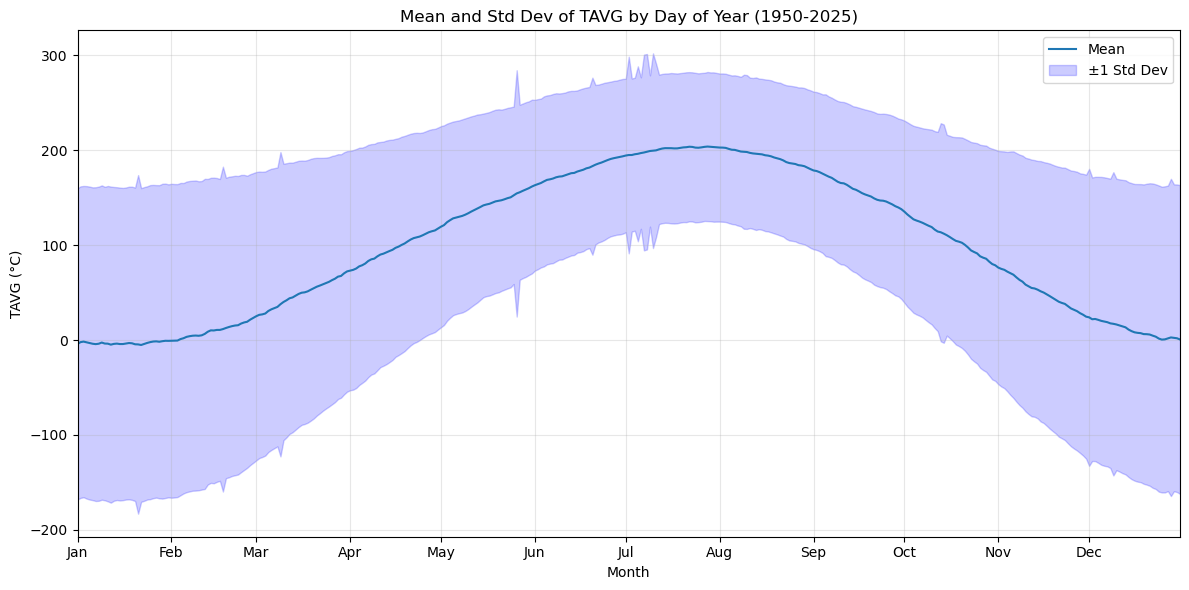

In [7]:

from compute_PCA_vectors.dask_pca import plot_mean_std
# Use the function on the TAVG data
daily_means, daily_stds = plot_mean_std(tavg_data, title="Mean and Std Dev of TAVG by Day of Year (1950-2025)", ylabel="TAVG (°C)")



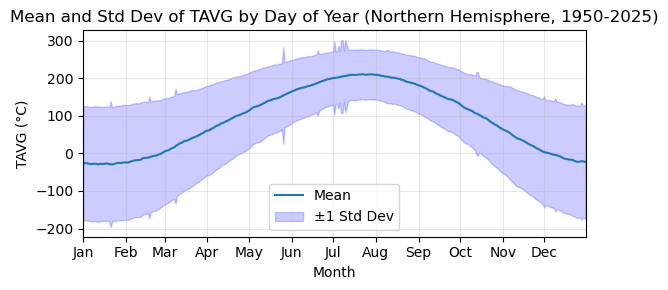

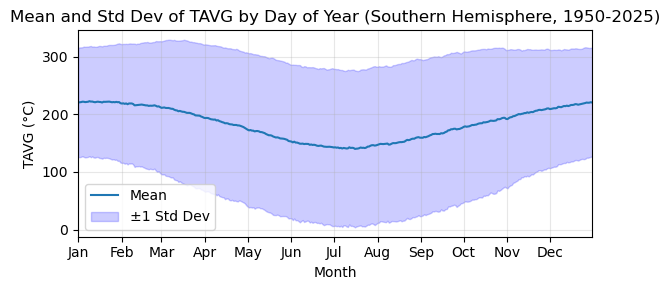

In [17]:
import matplotlib.pyplot as plt

# Compute hemisphere for each station based on latitude
tavg_data['hemisphere'] = tavg_data['latitude'].map(lambda lat: 'Northern' if lat >= 0 else 'Southern', meta=('latitude', 'object'))

# Use plot_mean_std for hemisphere subsets, store outputs
northern_df = tavg_data[tavg_data['hemisphere'] == 'Northern']
southern_df = tavg_data[tavg_data['hemisphere'] == 'Southern']

northern_mean, northern_std = plot_mean_std(
    northern_df,
    title="Mean and Std Dev of TAVG by Day of Year (Northern Hemisphere, 1950-2025)",
    ylabel="TAVG (°C)"
)

southern_mean, southern_std = plot_mean_std(
    southern_df,
    title="Mean and Std Dev of TAVG by Day of Year (Southern Hemisphere, 1950-2025)",
    ylabel="TAVG (°C)"
)


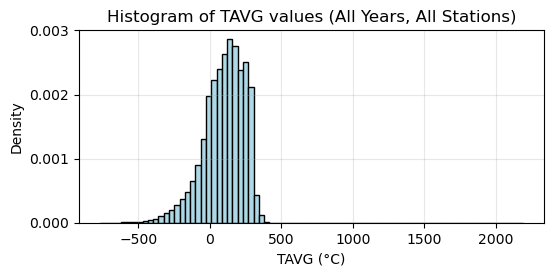

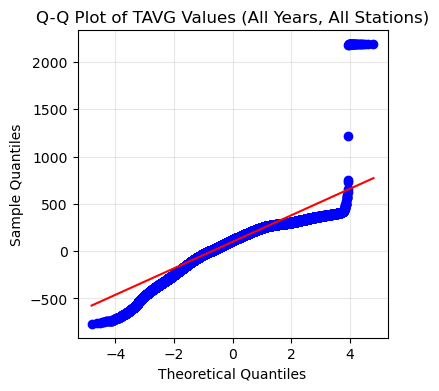

In [18]:
import numpy as np
import pandas as pd
import scipy.stats as stats

# Compute TAVG values as a single array (all days, all stations, all years)
# Collect all day columns
day_cols = [col for col in tavg_data.columns if col.startswith('day_')]
# Only keep rows with some non-null day values
tavg_nonnull = tavg_data[day_cols].dropna(how='all', subset=day_cols)

# Compute on small sample if data is too big for memory

#  sampling with Dask
tavg_pandas = tavg_nonnull[day_cols].sample(frac=0.01, random_state=0).compute()  # sample 5%
tavg_values = tavg_pandas.values.flatten()
tavg_values = tavg_values[~np.isnan(tavg_values)]

# Plot histogram
plt.figure(figsize=(6, 2.5))
plt.hist(tavg_values, bins=80, density=True, color='lightblue', edgecolor='black')
plt.title("Histogram of TAVG values (All Years, All Stations)")
plt.xlabel("TAVG (°C)")
plt.ylabel("Density")
plt.grid(alpha=0.3)
plt.show()

# Q-Q plot
plt.figure(figsize=(4, 4))
stats.probplot(tavg_values, dist="norm", plot=plt)
plt.title("Q-Q Plot of TAVG Values (All Years, All Stations)")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")
plt.grid(alpha=0.3)
plt.show()


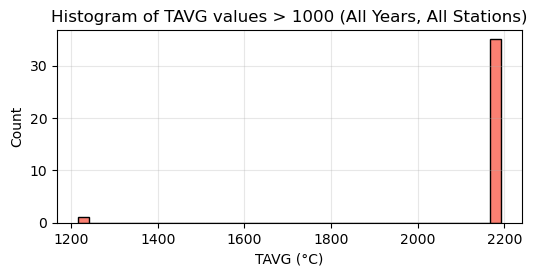

: 

In [ ]:
# Draw histogram of TAVG values greater than 1000
large_tavg_values = tavg_values[tavg_values > 1000]

plt.figure(figsize=(6, 2.5))
plt.hist(large_tavg_values, bins=40, density=False, color='salmon', edgecolor='black')
plt.title("Histogram of TAVG values > 1000 (All Years, All Stations)")
plt.xlabel("TAVG (°C)")
plt.ylabel("Count")
plt.grid(alpha=0.3)
plt.show()
